# Grado en Ingeniería Informática
### **Asignatura**: Tratamiento de Señales Visuales/Tratamiento de Señales Multimedia I
### Práctica 4: Reconocimiento de escenas con Deep Learning

#### Pregunta 5

---

Autor: Rodrigo Juez Hernández (rodrigo.juezh@estudiante.uam.es), Universidad Autónoma de Madrid


# 0. Valores a probar en esta pregunta

In [ ]:
BEST_IMG_SIZE = 224
BEST_BATCH_SIZE = 8 # numero de elementos procesados conjuntamente en cada iteracion
BEST_ACTIVATION = "relu"
EPOCHS = 15 # numero de epocas para entrenamiento

# 1. Entorno
(Ejecuta una vez y compacta para que no moleste)

#### Entorno de trabajo
Instalación de librerías, comprobación de versiones, carga de dataset y elección de hardware.

In [ ]:
#%%capture
#%tensorflow_version 2.x
!pip install tensorflow==2.3.0
import tensorflow as tf
import numpy as np
import os, subprocess, pathlib, time
from google.colab import drive
import matplotlib.pyplot as plt

import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optimizers


     |████████████████████████████████| 320.4 MB 45 kB/s 
     |████████████████████████████████| 2.9 MB 33.4 MB/s 
     |████████████████████████████████| 459 kB 32.1 MB/s 
     |████████████████████████████████| 20.1 MB 1.9 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.7.0
    Uninstalling tensorflow-2.7.0:
 

In [ ]:
!python --version                     # mostrar version de python
print('Tensorflow ' + tf.__version__) # mostrar version tensorflow


# Montar Google Drive y crear carpetas
drive.mount('/content/gdrive', force_remount=True)

work_dir = '/content/work_dir'                    # directorio de trabajo en local (mas rapido)
dwld_dir = '/content/gdrive/My Drive/dwld_dir'    # directorio de descarga en Google drive personal
subprocess.call(["mkdir","-p",work_dir])          # crear directorio para trabajo
subprocess.call(["mkdir","-p",dwld_dir+'/dataset/'])  # crear directorio para dataset

os.chdir(dwld_dir+'/dataset/')                        # posicionarse en el directorio
# Descargar dataset scenes15 si no esta disponible
if os.path.isfile('./dataset_scenes15.zip') == False: 
  !wget http://www-vpu.eps.uam.es/~jcs/tsv/dataset_scenes15.zip 
  
# Copiar el dataset al directorio local (mayor velocidad de lectura que en Gdrive)
!cp /content/gdrive/My\ Drive/dwld_dir/dataset/dataset_scenes15.zip /content/work_dir/

os.chdir(work_dir)                        # posicionarse en el directorio
if os.path.isdir('./scenes15') == False: 
  !unzip -o -q dataset_scenes15.zip -d .

print('El dataset se encuentra descargado en el directorio {} \ny descomprimido en el directorio {} (usado para lectura de datos)'.format(dwld_dir, work_dir))

Python 3.7.12
Tensorflow 2.3.0
Mounted at /content/gdrive
--2021-12-20 20:32:13--  http://www-vpu.eps.uam.es/~jcs/tsv/dataset_scenes15.zip
Resolving www-vpu.eps.uam.es (www-vpu.eps.uam.es)... 150.244.56.90
Connecting to www-vpu.eps.uam.es (www-vpu.eps.uam.es)|150.244.56.90|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86359960 (82M) [application/zip]
Saving to: ‘dataset_scenes15.zip’

dataset_scenes15.zi 100%[===================>]  82.36M  32.1MB/s    in 2.6s    

2021-12-20 20:32:16 (32.1 MB/s) - ‘dataset_scenes15.zip’ saved [86359960/86359960]

El dataset se encuentra descargado en el directorio /content/gdrive/My Drive/dwld_dir 
y descomprimido en el directorio /content/work_dir (usado para lectura de datos)


In [ ]:
dataset_dir = pathlib.Path(work_dir + '/scenes15/')

# Obtener etiquetas de clase y numero de clases
CLASS_NAMES = np.array([item.name for item in dataset_dir.glob('*')]) #clases son subdirectorios de '/train/'
NUM_CLASSES = len(CLASS_NAMES) # numero total de clases

# 2. Preparación pregunta
Funciones para que instancian el generador, y el modelo para llamarlas reiteradamente.

#### Preparar dataset

In [ ]:
def generator_dataset(BATCH_SIZE = 16, IMG_HEIGHT = 32, IMG_WIDTH = 32, IMG_CHANNELS = 3):  
  img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.20)

  # Obtenemos un iterador sobre los datos de entrenamiento del dataset
  # aplicando el ImageDataGenerator creado anteriormente

  train_data_gen = img_gen.flow_from_directory(directory=str(dataset_dir),
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode='rgb',                                                     
                                            classes = list(CLASS_NAMES),
                                            class_mode='categorical',
                                            batch_size=BATCH_SIZE, 
                                            subset="training",                                         
                                            shuffle=True,
                                            seed=0)

  test_data_gen = img_gen.flow_from_directory(directory=str(dataset_dir),
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode='rgb',                                                     
                                            classes = list(CLASS_NAMES),
                                            class_mode='categorical',
                                            batch_size=BATCH_SIZE,
                                            subset="validation",
                                            shuffle=True,
                                            seed=0)
  
  return train_data_gen, test_data_gen


# 3. Modelos Propuestos
Funciones que instancian los modelos que he propuesto para esta pregunta.
No todos los modelos que creemos aquí van a ser ejecutados, hemos hecho pruebas y finalmente hemos considerado los que si que vamos a incluir en el apartado de Ejecución.



#### Modelo Tutorial

In [ ]:
def model_DEFAULT_ADAM(IMG_HEIGHT = 224, IMG_WIDTH = 224, IMG_CHANNELS = 3, ACTIVATION = "relu", print_summary = False):  
  # definir modelo de red
  model = models.Sequential()

  # incluir capa convolucional C1
  model.add(layers.Conv2D(filters=6, 
                          kernel_size=(3, 3), 
                          strides = (1,1),
                          padding = 'valid',
                          activation=ACTIVATION, 
                          input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)))

  # incluir average pooling S2
  model.add(layers.AveragePooling2D())

  # incluir capa convolucional C3
  model.add(layers.Conv2D(filters=16, 
                          kernel_size=(3, 3),
                          strides = (1,1),
                          padding = 'valid', 
                          activation=ACTIVATION))

  # incluir average pooling S4
  model.add(layers.AveragePooling2D())

  # convertir el volumen de datos en vector fila para conectarlo con capa FC
  model.add(layers.Flatten())

  # incluir fully convolutional F5
  model.add(layers.Dense(units=120, activation=ACTIVATION))

  # incluir fully convolutional F6
  model.add(layers.Dense(units=84, activation=ACTIVATION))

  # incluir salida OUTPUT
  model.add(layers.Dense(units=NUM_CLASSES, activation = 'softmax'))


  # mostar resumen
  if print_summary == True:
    model.summary()


  # definicion con optimizador con valores definidos por el usuario
  LEARNING_RATE = 0.001 # factor de aprendizaje
  model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),            
              loss='categorical_crossentropy',            
              metrics=['accuracy'])

  return model
model_DEFAULT_ADAM(print_summary = True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_190 (Conv2D)          (None, 222, 222, 6)       168       
_________________________________________________________________
average_pooling2d_20 (Averag (None, 111, 111, 6)       0         
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 109, 109, 16)      880       
_________________________________________________________________
average_pooling2d_21 (Averag (None, 54, 54, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 46656)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 120)               5598840   
_________________________________________________________________
dense_14 (Dense)             (None, 84)               

#### Modelo VGG16

Elegido por la simplicidad de la arquitectura, y aunque dicen que es demasiado costoso de entrenar comparado con otros modelos, nosotros vamos a usar transfer learning por lo que no tenemos ese inconveniente.


In [ ]:
def model_VGG16(IMG_HEIGHT = 224, IMG_WIDTH = 224, IMG_CHANNELS = 3, ACTIVATION = "relu", print_summary = False):  
  vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
  vgg.trainable = False

  flatten = layers.Flatten()
  fully_connected = layers.Dense(units=120, activation = ACTIVATION)
  output_layer = layers.Dense(units=NUM_CLASSES, activation = 'softmax')
  model = tf.keras.Sequential([
    vgg,
    flatten,
    fully_connected,
    output_layer
  ])


  # mostar resumen
  if print_summary == True:
    model.summary()


  # definicion con optimizador con valores definidos por el usuario
  LEARNING_RATE = 0.001 # factor de aprendizaje
  model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),            
              loss='categorical_crossentropy',            
              metrics=['accuracy'])

  return model

model_VGG16(print_summary = True)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 120)               3010680   
_________________________________________________________________
dense_17 (Dense)             (None, 15)                1815      
Total params: 17,727,183
Trainable params: 3,012,495
Non-trainable params: 14,714,688
_________________________________________________________________


#### Modelo ResNet50

Elegido por la simplicidad de la arquitectura, y aunque dicen que es demasiado costoso de entrenar comparado con otros modelos, nosotros vamos a usar transfer learning por lo que no tenemos ese inconveniente.


In [ ]:
def model_RESNET(IMG_HEIGHT = 224, IMG_WIDTH = 224, IMG_CHANNELS = 3, ACTIVATION = "relu", print_summary = False):  
  res_net = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
  res_net.trainable = False

  flatten = layers.GlobalAveragePooling2D()
  fully_connected = layers.Dense(units=120, activation = ACTIVATION)
  output_layer = layers.Dense(units=NUM_CLASSES, activation = 'softmax')
  model = tf.keras.Sequential([
    res_net,
    flatten,
    fully_connected,
    output_layer
  ])


  # mostar resumen
  if print_summary == True:
    model.summary()


  # definicion con optimizador con valores definidos por el usuario
  LEARNING_RATE = 0.001 # factor de aprendizaje
  model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),            
              loss='categorical_crossentropy',            
              metrics=['accuracy'])

  return model

model_RESNET(print_summary = True)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 120)               245880    
_________________________________________________________________
dense_19 (Dense)             (None, 15)                1815      
Total params: 23,835,407
Trainable params: 247,695
Non-trainable params: 23,587,712
_________________________________________________________________


# 4. Ejecución

In [ ]:
IMG_CHANNELS = 3

test_loss_list = []
test_acc_list = []

train_loss_list = []
train_acc_list = []

test_loss_list = []
test_acc_list = []

train_loss_list = []
train_acc_list = []

history_acc_list = []
history_val_acc_list = []
history_loss_list = []
history_val_loss_list = []


models_tested = {
    "ResNet50": model_RESNET(IMG_HEIGHT = BEST_IMG_SIZE, IMG_WIDTH = BEST_IMG_SIZE, IMG_CHANNELS = IMG_CHANNELS, print_summary = False),
    
    "VGG16": model_VGG16(IMG_HEIGHT = BEST_IMG_SIZE, IMG_WIDTH = BEST_IMG_SIZE, IMG_CHANNELS = IMG_CHANNELS, print_summary = False),

    "TUTORIAL_ADAM": model_DEFAULT_ADAM(IMG_HEIGHT = BEST_IMG_SIZE, IMG_WIDTH = BEST_IMG_SIZE, IMG_CHANNELS = IMG_CHANNELS, print_summary = False)


  }


for model_name, model in models_tested.items():
  print(f"{'='*10} INICIANDO MODEL con NOMBRE {model_name} {'='*10}")
  
  train_data_gen, test_data_gen = generator_dataset(BATCH_SIZE = BEST_BATCH_SIZE, IMG_HEIGHT = BEST_IMG_SIZE, IMG_WIDTH = BEST_IMG_SIZE, IMG_CHANNELS = IMG_CHANNELS)

  with tf.device('/GPU:0'):
    history = model.fit_generator(
        generator=train_data_gen,          
        steps_per_epoch=train_data_gen.n // BEST_BATCH_SIZE,      
        validation_data=test_data_gen,
        validation_steps=test_data_gen.n // BEST_BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1     
    )


    
  
        
    test_loss, test_acc = model.evaluate_generator( generator=test_data_gen, 
                                                    steps = test_data_gen.n // BEST_BATCH_SIZE, 
                                                    verbose=1)

    train_loss, train_acc = model.evaluate_generator( generator=train_data_gen, 
                                                    steps = train_data_gen.n // BEST_BATCH_SIZE, 
                                                    verbose=1)

  


  ############### APARTIR DE AQUÍ ES PARA DEBUGEAR Y GUARDAR RESULTADOS
  test_loss_list.append(test_loss)
  test_acc_list.append(test_acc)

  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)

  history_acc_list.append(history.history['accuracy']         )
  history_val_acc_list.append(history.history['val_accuracy'] )

  history_loss_list.append(history.history['loss']            )
  history_val_loss_list.append(history.history['val_loss']    )


  ################# POR SI SE DESCONECTA A LA MITAD EL GOOGLE COLAB PODEMOS RECUPERAR PARTE DE LA EJECUCIÓN Y SOLO EJECUTAR LAS REDES QUE NO HAYAN TERMINADO
  print("test_loss_list = ", test_loss_list)
  print("test_acc_list = ", test_acc_list)

  print("train_loss_list = ", train_loss_list)
  print("train_acc_list = ", train_acc_list)

  print("history_acc_list = ", history_acc_list)
  print("history_val_acc_list = ", history_val_acc_list)
  print("history_loss_list = ", history_loss_list)
  print("history_val_loss_list = ", history_val_loss_list)
  
  

========== INICIANDO MODEL con NOMBRE ResNet50 ==========
Found 3592 images belonging to 15 classes.
Found 893 images belonging to 15 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
449/449 [==============================] - 44s 98ms/step - loss: 2.4985 - accuracy: 0.1874 - val_loss: 2.3352 - val_accuracy: 0.2477
Epoch 2/15
449/449 [==============================] - 44s 98ms/step - loss: 2.1529 - accuracy: 0.2876 - val_loss: 2.2006 - val_accuracy: 0.2466
Epoch 3/15
449/449 [==============================] - 44s 98ms/step - loss: 1.9796 - accuracy: 0.3463 - val_loss: 2.0066 - val_accuracy: 0.3390
Epoch 4/15
449/449 [==============================] - 44s 98ms/step - loss: 1.8531 - accuracy: 0.3778 - val_loss: 1.8889 - val_accuracy: 0.3773
Epoch 5/15
449/449 [==============================] - 44s 99ms/step - loss: 1.7655 - accuracy: 0.4129 - val_loss: 1.8323 - val_accuracy: 0.3998
Epoch 6/15
449/449 [==============================] - 44s 98m

# 5. Plotting resultados

In [ ]:
print(models_tested.keys())
print("test_loss_list = ", test_loss_list)
print("test_acc_list = ", test_acc_list)

print("train_loss_list = ", train_loss_list)
print("train_acc_list = ", train_acc_list)

print("history_acc_list = ", history_acc_list)
print("history_val_acc_list = ", history_val_acc_list)
print("history_loss_list = ", history_loss_list)
print("history_val_loss_list = ", history_val_loss_list)

dict_keys(['ResNet50', 'VGG16', 'TUTORIAL_ADAM'])
test_loss_list =  [1.49586021900177, 0.8816933631896973, 3.6174635887145996]
test_acc_list =  [0.5202702879905701, 0.8186936974525452, 0.47297295928001404]
train_loss_list =  [1.279516577720642, 0.0111855398863554, 0.0014813165180385113]
train_acc_list =  [0.5826837420463562, 0.9977728128433228, 0.9997215867042542]
history_acc_list =  [[0.18736080825328827, 0.28758352994918823, 0.346325159072876, 0.37778395414352417, 0.4128619134426117, 0.4423719346523285, 0.464643657207489, 0.48301783204078674, 0.49192649126052856, 0.5103006958961487, 0.5208797454833984, 0.5239421129226685, 0.5347995758056641, 0.5503897666931152, 0.5556792616844177], [0.6673162579536438, 0.8869710564613342, 0.9571269750595093, 0.981069028377533, 0.9846882224082947, 0.9935969114303589, 0.993318498134613, 0.9908128976821899, 0.9613028764724731, 0.9894209504127502, 0.9944320917129517, 0.9983296394348145, 0.9910913109779358, 0.9741091132164001, 0.9863585829734802], [0.2293

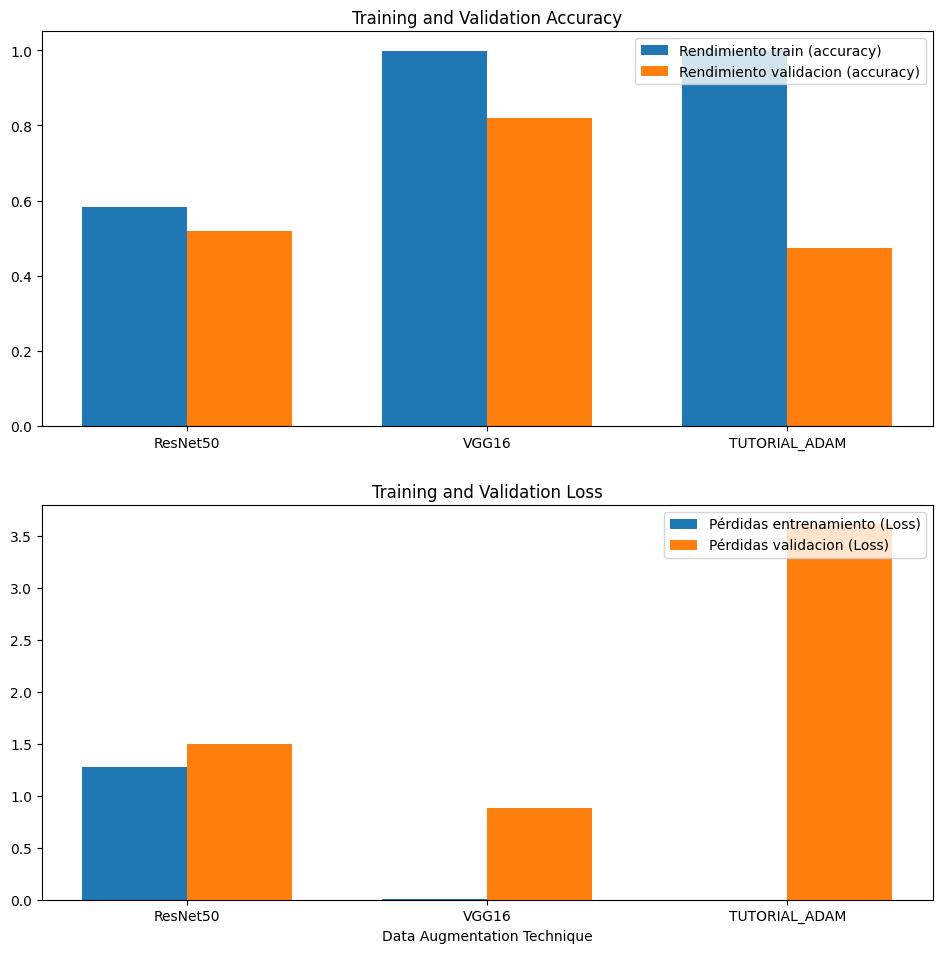

In [ ]:
ind = np.arange(len(models_tested))
width = 0.35 

fig, axs = plt.subplots(2,1)
axs[0].bar(ind, train_acc_list,width,  label='Rendimiento train (accuracy)')
axs[0].bar(ind + width, test_acc_list,width,  label='Rendimiento validacion (accuracy)')
axs[0].legend(loc='upper right')
axs[0].set_title('Training and Validation Accuracy')

axs[0].set_xticks(ind + width / 2)
axs[0].set_xticklabels(models_tested)




axs[1].bar(ind, train_loss_list,width,  label='Pérdidas entrenamiento (Loss)')
axs[1].bar(ind + width, test_loss_list,width,  label='Pérdidas validacion (Loss)')  
axs[1].legend(loc='upper right')
axs[1].set_title('Training and Validation Loss')

axs[1].set_xticks(ind + width / 2)
axs[1].set_xticklabels(models_tested)
axs[1].set_xlabel('Data Augmentation Technique')


fig.set_size_inches(11.5, 11.5)
fig.set_dpi(100)
plt.show()

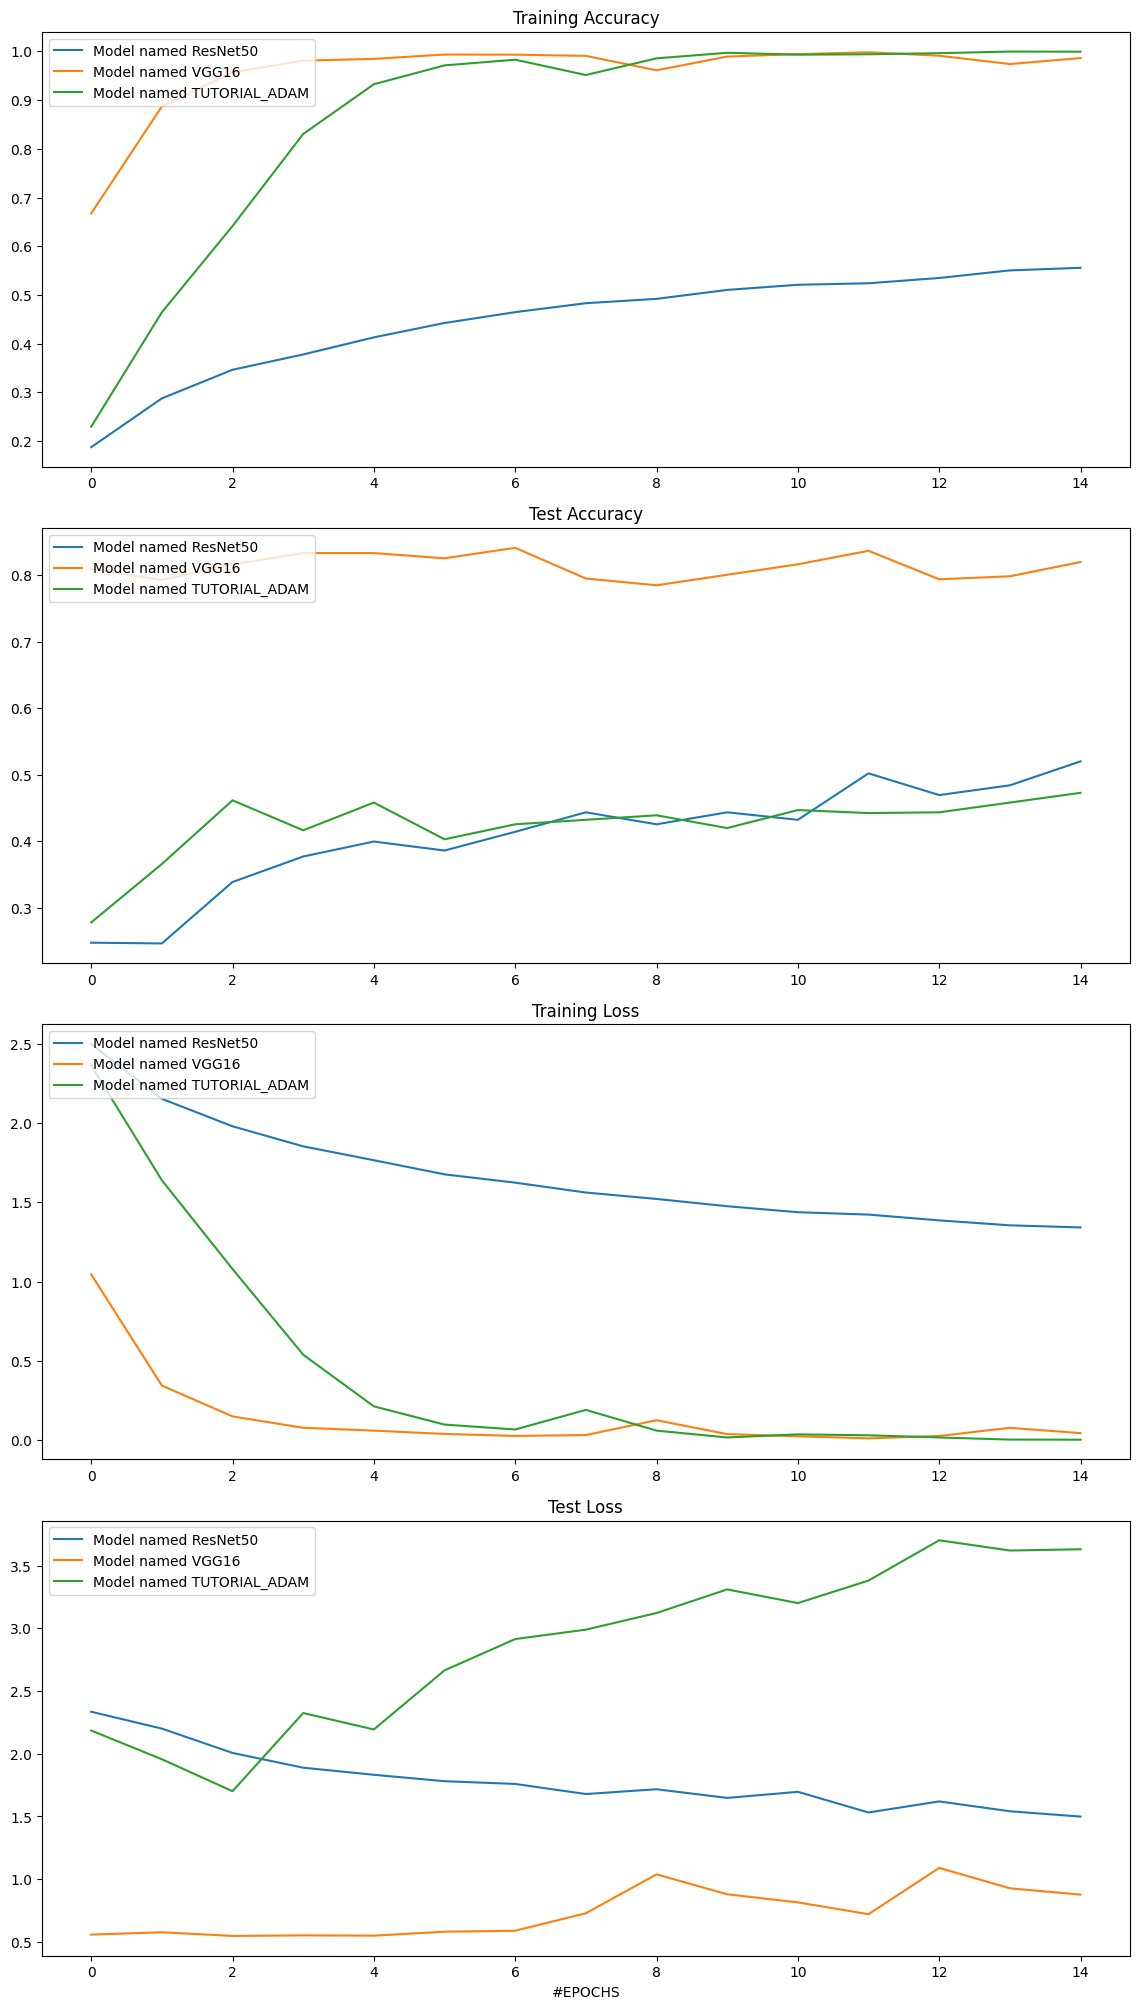

In [ ]:
fig, axs = plt.subplots(4,1)
epoch_list = np.arange(EPOCHS)

for idx, batch_size in enumerate(models_tested):
  axs[0].plot(epoch_list, history_acc_list[idx],  label=f'Model named {batch_size}')
  axs[0].set_title(f'Training Accuracy')
  axs[0].legend(loc='upper left')

for idx, batch_size in enumerate(models_tested):
  axs[1].plot(epoch_list, history_val_acc_list[idx],  label=f'Model named {batch_size}')
  axs[1].set_title(f'Test Accuracy')
  axs[1].legend(loc='upper left')


for idx, batch_size in enumerate(models_tested):
  axs[2].plot(epoch_list, history_loss_list[idx],  label=f'Model named {batch_size}')
  axs[2].set_title(f'Training Loss')
  axs[2].legend(loc='upper left')


for idx, batch_size in enumerate(models_tested):
  axs[3].plot(epoch_list, history_val_loss_list[idx],  label=f'Model named {batch_size}')
  axs[3].set_title(f'Test Loss')
  axs[3].legend(loc='upper left')


  
  

fig.set_size_inches(11.5, 20)
fig.set_dpi(100)
plt.tight_layout()
plt.xlabel("#EPOCHS")
plt.show()